In [1]:
library(Seurat)
library(ggplot2)
library(enrichR)
library(stringr)
library(RColorBrewer)
library(pheatmap)
library(dplyr)
library(scales)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(tidyr)
library(tibble)

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.3”

Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!

Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from

In [ ]:
ifnb = readRDS("hc_rbd_pd_joint_integrated.rds")

In [3]:
ifnb_testct <- subset(ifnb, subset = celltype == "microglia")

In [4]:
set.seed(384)
ifnb_testct <- FindNeighbors(ifnb_testct, reduction = "integrated.cca", dims = 1:30)
ifnb_testct <- FindClusters(ifnb_testct, resolution = 0.5)
ifnb_testct <- RunUMAP(ifnb_testct, dims = 1:30, reduction = "integrated.cca")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11332
Number of edges: 631561

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8353
Number of communities: 11
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
01:04:01 UMAP embedding parameters a = 0.9922 b = 1.112

01:04:01 Read 11332 rows and found 30 numeric columns

01:04:01 Using Annoy for neighbor search, n_neighbors = 30

01:04:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:04:04 Writing NN index file to temp file /tmp/RtmpsAVFnx/file247a5b119934ad

01:04:04 Searching Annoy index using 1 thread, search_k = 3000

01:04:07 Annoy recall = 64.28%

01:04:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighb

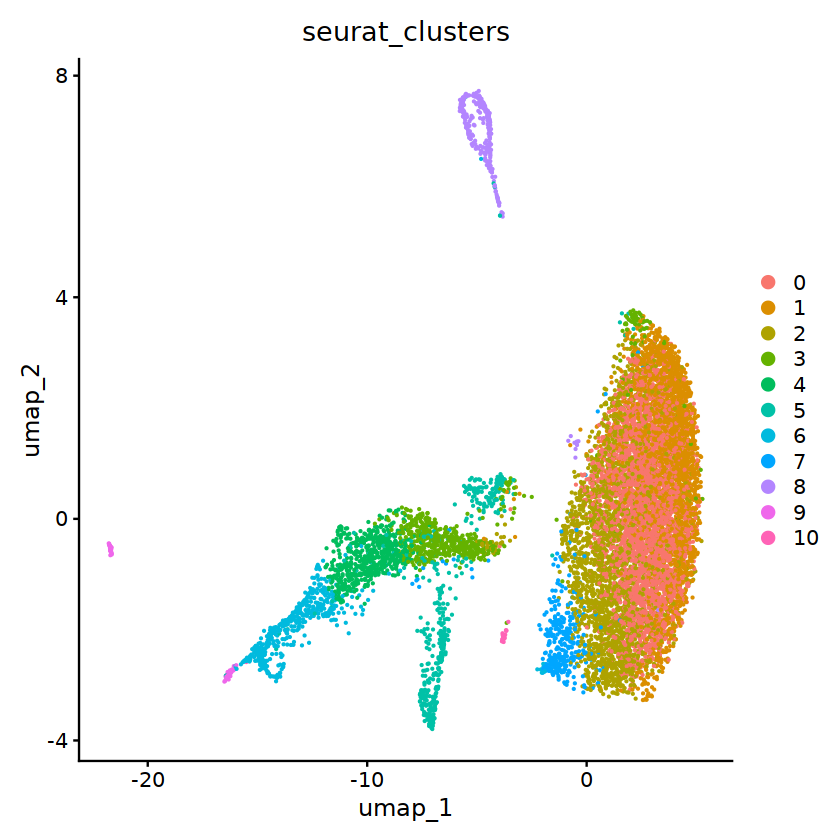

In [5]:
DimPlot(ifnb_testct, reduction = "umap", group.by = c("seurat_clusters"))

# DEG analysis (PD vs HC) for each Mic subtype

In [6]:
set.seed(384)
# Set cluster as the main identity
Idents(ifnb_testct) <- "seurat_clusters"

# Initialize a list to store DEG results for each cluster
deg_results_by_cluster <- list()

# Loop through each cluster
for (cluster in unique(ifnb_testct$seurat_clusters)) {
  # Subset the Seurat object to only include cells from the current cluster
  cluster_subset <- subset(ifnb_testct, idents = cluster)
  
  # Set disease as the identity for this subset
  Idents(cluster_subset) <- "disease"
  
  # Check if both "PD" and "HC" are present in the subset
  if (all(c("PD", "HC") %in% unique(Idents(cluster_subset)))) {
    # Perform differential expression analysis between "PD" and "HC" within this cluster
    deg_results <- FindMarkers(cluster_subset, ident.1 = "PD", ident.2 = "HC")
    
    # Store the results in the list, using the cluster as the name
    deg_results_by_cluster[[paste0("Cluster_", cluster)]] <- deg_results
  } else {
    # If one of the groups is missing, print a message and skip the cluster
    message(paste("Skipping cluster", cluster, "- does not contain both PD and HC cells"))
  }
}

# View results for a specific cluster, e.g., Cluster 0
if ("Cluster_0" %in% names(deg_results_by_cluster)) {
  head(deg_results_by_cluster[["Cluster_0"]])
} else {
  message("No results for Cluster 0")
}


Skipping cluster 9 - does not contain both PD and HC cells



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MALAT1,7.225861e-56,-0.3281136,1.000,1.000,2.644737e-51
XIST,3.164694e-40,-1.4091072,0.248,0.518,1.158310e-35
F13A1,3.374431e-31,3.0054084,0.151,0.028,1.235076e-26
HSPA1A,5.866158e-31,-1.4297470,0.211,0.433,2.147073e-26
UTY,1.435122e-29,1.0683481,0.410,0.191,5.252689e-25
LINC00278,2.184820e-27,1.2376196,0.317,0.132,7.996661e-23


In [13]:
library(openxlsx)

# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in setdiff(0:10, 9)) {
    # Filter the data for each cluster
    cluster_data <- deg_results_by_cluster[[paste0("Cluster_", i)]] %>% filter(p_val_adj < 0.05)
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/DEGs_PD_vs_HC/Significant_DEGs_PD_vs_HC.xlsx", overwrite = TRUE)


## GO enrichment on DEGs for each Mic subtype

In [7]:
go_analysis <- function(deg_results_by_cluster, log2FC_threshold = 0.0){
    set.seed(384)
    # Define the database(s) to use for EnrichR, focusing on GO Biological Process
    dbs <- c("GO_Biological_Process_2021")
    
    # Initialize a list to store enrichment results
    enrichment_results <- list()
    marker_counts <- list() 
    
    # Loop over each cluster in deg_results_by_cluster to perform enrichment analysis
    for (cluster_name in names(deg_results_by_cluster)) {
      # Retrieve DEGs for the current cluster from deg_results_by_cluster
      cluster_data <- deg_results_by_cluster[[cluster_name]]
      
      # Select significant DEGs (e.g., adjusted p-value < 0.05 and log fold change threshold)
      significant_genes <- rownames(cluster_data[cluster_data$p_val_adj < 0.05 & abs(cluster_data$avg_log2FC) > log2FC_threshold, ])
      marker_counts[[cluster_name]] <- length(significant_genes)
        
      # Perform enrichment analysis if there are significant genes
      if (length(significant_genes) > 0) {
        enrich_result <- enrichr(significant_genes, dbs)
        go_results <- enrich_result[["GO_Biological_Process_2021"]]
        
        # Sort results by adjusted p-value and select the top 10 processes
        go_results <- go_results[order(go_results$Adjusted.P.value), ]
        top_processes <- head(go_results, 5)
    
        if (nrow(top_processes) != 0) {
            # Initialize list to store the average fold change for each GO term
            avg_fc_for_terms <- numeric(nrow(top_processes))
            
            # Calculate the average fold change for each GO term in top_processes
            for (j in 1:nrow(top_processes)) {
              if (!is.na(top_processes$Genes[j]) && top_processes$Genes[j] != "") {
                genes_in_term <- strsplit(as.character(top_processes$Genes[j]), ";")[[1]]  # Split the genes string by semicolon
                
                # Only keep genes that are present in cluster_data
                genes_in_term <- genes_in_term[genes_in_term %in% rownames(cluster_data)]
                  
                # Retrieve fold changes for these genes
                if (length(genes_in_term) > 0) {
                  fc_values <- cluster_data[genes_in_term, "avg_log2FC"]
                  avg_fc_for_terms[j] <- mean(fc_values, na.rm = TRUE)  # Calculate the average, ignoring NA values
                } else {
                  avg_fc_for_terms[j] <- NA  # If no genes are found, set to NA
                }
              } else {
                avg_fc_for_terms[j] <- NA  # If 'Genes' is NA, set to NA
              }
            }
        
            # Add the average fold changes as a new column in top_processes
            top_processes$Avg_Log2FC <- avg_fc_for_terms
        }
        # Store the top GO processes for this cluster
        enrichment_results[[cluster_name]] <- top_processes
      }
    }
    return(list(marker_counts = marker_counts, enrichment_results = enrichment_results))
}

In [8]:
set.seed(384)
output <- go_analysis(deg_results_by_cluster)
list2env(output, envir = .GlobalEnv)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


<environment: R_GlobalEnv>

In [9]:
marker_counts

$Cluster_8
[1] 93

$Cluster_0
[1] 96

$Cluster_6
[1] 15

$Cluster_5
[1] 75

$Cluster_2
[1] 146

$Cluster_3
[1] 34

$Cluster_1
[1] 70

$Cluster_7
[1] 1

$Cluster_4
[1] 10

$Cluster_10
[1] 0

In [ ]:
enrichment_results <- readRDS("../../DEG_GO_Analysis/GO_PD_vs_HC/cached_enrichment_results.rds")
set.seed(384) 
# Prepare matrices for plotting
# Collect unique biological processes across all clusters
all_processes <- unique(unlist(lapply(enrichment_results, function(x) x$Term)))
enrichment_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                            dimnames = list(all_processes, paste0("Cluster_", 0:10)))
fc_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                    dimnames = list(all_processes, paste0("Cluster_", 0:10)))

# Fill the matrices with -log10(adjusted p-value) and Avg_Log2FC for each process and cluster
for (i in 0:10) {
  cluster_name <- paste0("Cluster_", i)
  if (!is.null(enrichment_results[[cluster_name]]) && nrow(enrichment_results[[cluster_name]]) > 0) {
    for (j in 1:nrow(enrichment_results[[cluster_name]])) {
      process <- enrichment_results[[cluster_name]]$Term[j]
      pval <- enrichment_results[[cluster_name]]$Adjusted.P.value[j]
      avg_log2fc <- enrichment_results[[cluster_name]]$Avg_Log2FC[j]
  
      # Fill p-value matrix with -log10(p-value)
      enrichment_matrix[process, cluster_name] <- -log10(pval)
      
      # Fill fold change matrix with Avg_Log2FC
      fc_matrix[process, cluster_name] <- avg_log2fc
      
    }
  }
}   

# Replace NA values with a low number (e.g., 0) for better plotting
enrichment_matrix[is.na(enrichment_matrix)] <- 0

output_pdf = "../../man_figs_pdf/mic_deg_go_PDvsHC_logp.pdf"
# Plot the heatmap using pheatmap
pheatmap::pheatmap(enrichment_matrix,
                   color = c(
                     colorRampPalette(c("white", '#ef3b2c'))(10),  # More resolution for small values
                     colorRampPalette(c('#ef3b2c','#cb181d','#a50f15','#67000d'))(90) # High contrast for larger values
                   ),
                   na_col = "grey",           # Use grey for NA values (e.g., processes not enriched in clusters)
                   main = "Enriched BP of Microglial State Signatures (-log10 p-value)",
                   cluster_rows = FALSE,       # Cluster processes for better visualization
                   cluster_cols = FALSE,      # Do not cluster clusters (retain the original order)
                   angle_col = 45,            # Rotate column names for readability
                   fontsize_row = 6,          # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)         # Font size for cluster labels
print("Logp Plot saved")

# Replace NA values with a low number (e.g., 0) for better plotting
fc_matrix[is.na(fc_matrix)] <- 0

# Define the custom color palettes
# negative_colors <- colorRampPalette(c('#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6', '#2171b5', '#084594'))(50)
negative_colors <- colorRampPalette(c('#084594','#2171b5','#4292c6','#6baed6','#9ecae1','#c6dbef', '#deebf7', '#f7fbff'))(50)
positive_colors <- colorRampPalette(c('#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d'))(50)

# Combine palettes with white at 0
custom_colors <- c(negative_colors, "white", positive_colors)

# Define custom breaks to center the color scale at 0
max_abs_value <- max(abs(fc_matrix))
breaks <- seq(-max_abs_value, max_abs_value, length.out = length(custom_colors) + 1)

output_pdf = "../../man_figs_pdf/mic_deg_go_PDvsHC_log2fc.pdf"
pheatmap::pheatmap(fc_matrix,
                   color = custom_colors,
                   breaks = breaks,              # Use custom breaks for diverging colors
                   na_col = "grey",              # Use grey for NA values
                   main = "Average Log2 Fold Change",
                   cluster_rows = FALSE,          # Cluster processes for better visualization
                   cluster_cols = FALSE,          # Cluster clusters for better visualization
                   angle_col = 45,               # Rotate column names for readability
                   fontsize_row = 6,             # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)             # Font size for cluster labels
print("Log2FC File saved")                                                  

[1] "Logp Plot saved"
[1] "Log2FC File saved"


In [12]:
for (i in 0:10){
    print(paste0("For cluster ", i))
    print(enrichment_results[[paste0("Cluster_", i)]]$Term)
    print(enrichment_results[[paste0("Cluster_", i)]]$Avg_Log2FC)
}

[1] "For cluster 0"
[1] "cellular heat acclimation (GO:0070370)"                                                 
[2] "heat acclimation (GO:0010286)"                                                          
[3] "cellular response to heat (GO:0034605)"                                                 
[4] "response to unfolded protein (GO:0006986)"                                              
[5] "regulation of protein modification by small protein conjugation or removal (GO:1903320)"
[1] -1.323350 -1.323350 -1.121773 -1.121773 -1.165001
[1] "For cluster 1"
[1] "negative regulation of smooth muscle contraction (GO:0045986)"                                             
[2] "positive regulation of nucleotide-binding oligomerization domain containing signaling pathway (GO:0070426)"
[3] "heat acclimation (GO:0010286)"                                                                             
[4] "cellular heat acclimation (GO:0070370)"                                                     

In [13]:
enrichment_results[[paste0("Cluster_", 0)]]

,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes,Avg_Log2FC
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>
1,cellular heat acclimation (GO:0070370),3/6,2.121001e-06,0.0008696103,0,0,213.98925,2795.4748,HSPA6;HSPA1B;HSPA1A,-1.323350
2,heat acclimation (GO:0010286),3/6,2.121001e-06,0.0008696103,0,0,213.98925,2795.4748,HSPA6;HSPA1B;HSPA1A,-1.323350
3,cellular response to heat (GO:0034605),4/36,2.609683e-05,0.0071331346,0,0,27.00000,284.9498,HSP90AA1;HSPA6;HSPA1B;HSPA1A,-1.121773
4,response to unfolded protein (GO:0006986),4/49,8.949412e-05,0.0183462947,0,0,19.18744,178.8526,HSP90AA1;HSPA6;HSPA1B;HSPA1A,-1.121773
5,regulation of protein modification by small protein conjugation or removal (GO:1903320),3/20,1.151406e-04,0.0188830516,0,0,37.73624,342.2435,HSP90AA1;HSPA1B;HSPA1A,-1.165001


In [15]:
library(openxlsx)
# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in setdiff(0:10, 9)) {
    # Filter the data for each cluster
    cluster_data <- enrichment_results[[paste0("Cluster_", i)]]
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/GO_PD_vs_HC/GO_Results_PD_vs_HC.xlsx", overwrite = TRUE)


In [16]:
saveRDS(enrichment_results, "DEG_GO_Analysis/GO_PD_vs_HC/cached_enrichment_results.rds")

# DEG analysis (RBD vs HC) for each Mic subtype

In [17]:
set.seed(384)
# Set cluster as the main identity
Idents(ifnb_testct) <- "seurat_clusters"

# Initialize a list to store DEG results for each cluster
deg_results_by_cluster <- list()

# Loop through each cluster
for (cluster in unique(ifnb_testct$seurat_clusters)) {
  # Subset the Seurat object to only include cells from the current cluster
  cluster_subset <- subset(ifnb_testct, idents = cluster)
  
  # Set disease as the identity for this subset
  Idents(cluster_subset) <- "disease"
  
  # Check if both "PD" and "HC" are present in the subset
  if (all(c("RBD", "HC") %in% unique(Idents(cluster_subset)))) {
    # Perform differential expression analysis between "PD" and "HC" within this cluster
    deg_results <- FindMarkers(cluster_subset, ident.1 = "RBD", ident.2 = "HC")
    
    # Store the results in the list, using the cluster as the name
    deg_results_by_cluster[[paste0("Cluster_", cluster)]] <- deg_results
  } else {
    # If one of the groups is missing, print a message and skip the cluster
    message(paste("Skipping cluster", cluster, "- does not contain both RBD and HC cells"))
  }
}

# View results for a specific cluster, e.g., Cluster 0
if ("Cluster_0" %in% names(deg_results_by_cluster)) {
  head(deg_results_by_cluster[["Cluster_0"]])
} else {
  message("No results for Cluster 0")
}


Skipping cluster 9 - does not contain both RBD and HC cells



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST,1.245590e-120,-3.470412,0.050,0.518,4.558983e-116
CSGALNACT1,1.935002e-89,-1.454575,0.484,0.804,7.082301e-85
DPYD,7.759763e-89,1.800638,0.676,0.348,2.840151e-84
TMEM163,1.649650e-77,1.477771,0.707,0.356,6.037886e-73
PVT1,6.768443e-74,2.003636,0.411,0.106,2.477318e-69
TTTY14,3.279730e-73,1.730527,0.419,0.109,1.200414e-68


In [18]:
library(openxlsx)

# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in setdiff(0:10, 9)) {
    # Filter the data for each cluster
    cluster_data <- deg_results_by_cluster[[paste0("Cluster_", i)]] %>% filter(p_val_adj < 0.05)
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/DEGs_RBD_vs_HC/Significant_DEGs_RBD_vs_HC.xlsx", overwrite = TRUE)

## GO enrichment on DEGs for each Mic subtype

In [19]:
output <- go_analysis(deg_results_by_cluster, log2FC_threshold = 0.0)
list2env(output, envir = .GlobalEnv)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


<environment: R_GlobalEnv>

In [21]:
marker_counts

$Cluster_8
[1] 81

$Cluster_0
[1] 839

$Cluster_6
[1] 54

$Cluster_5
[1] 152

$Cluster_2
[1] 370

$Cluster_3
[1] 34

$Cluster_1
[1] 225

$Cluster_7
[1] 11

$Cluster_4
[1] 35

$Cluster_10
[1] 0

In [ ]:
enrichment_results <- readRDS("../../DEG_GO_Analysis/GO_RBD_vs_HC/cached_enrichment_results.rds")
set.seed(384) 
# Prepare matrices for plotting
# Collect unique biological processes across all clusters
all_processes <- unique(unlist(lapply(enrichment_results, function(x) x$Term)))
enrichment_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                            dimnames = list(all_processes, paste0("Cluster_", 0:10)))
fc_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                    dimnames = list(all_processes, paste0("Cluster_", 0:10)))

# Fill the matrices with -log10(adjusted p-value) and Avg_Log2FC for each process and cluster
for (i in 0:10) {
  cluster_name <- paste0("Cluster_", i)
  if (!is.null(enrichment_results[[cluster_name]]) && nrow(enrichment_results[[cluster_name]]) > 0) {
    for (j in 1:nrow(enrichment_results[[cluster_name]])) {
      process <- enrichment_results[[cluster_name]]$Term[j]
      pval <- enrichment_results[[cluster_name]]$Adjusted.P.value[j]
      avg_log2fc <- enrichment_results[[cluster_name]]$Avg_Log2FC[j]
  
      # Fill p-value matrix with -log10(p-value)
      enrichment_matrix[process, cluster_name] <- -log10(pval)
      
      # Fill fold change matrix with Avg_Log2FC
      fc_matrix[process, cluster_name] <- avg_log2fc
      
    }
  }
}   

# Replace NA values with a low number (e.g., 0) for better plotting
enrichment_matrix[is.na(enrichment_matrix)] <- 0

output_pdf = "../../man_figs_pdf/mic_deg_go_RBDvsHC_logp.pdf"
# Plot the heatmap using pheatmap
pheatmap::pheatmap(enrichment_matrix,
                   color = c(
                     colorRampPalette(c("white", '#ef3b2c'))(10),  # More resolution for small values
                     colorRampPalette(c('#ef3b2c','#cb181d','#a50f15','#67000d'))(90) # High contrast for larger values
                   ),
                   na_col = "grey",           # Use grey for NA values (e.g., processes not enriched in clusters)
                   main = "Enriched BP of Microglial State Signatures (-log10 p-value)",
                   cluster_rows = FALSE,       # Cluster processes for better visualization
                   cluster_cols = FALSE,      # Do not cluster clusters (retain the original order)
                   angle_col = 45,            # Rotate column names for readability
                   fontsize_row = 6,          # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)         # Font size for cluster labels
print("Logp Plot saved")

# Replace NA values with a low number (e.g., 0) for better plotting
fc_matrix[is.na(fc_matrix)] <- 0

# Define the custom color palettes
# negative_colors <- colorRampPalette(c('#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6', '#2171b5', '#084594'))(50)
negative_colors <- colorRampPalette(c('#084594','#2171b5','#4292c6','#6baed6','#9ecae1','#c6dbef', '#deebf7', '#f7fbff'))(50)
positive_colors <- colorRampPalette(c('#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d'))(50)

# Combine palettes with white at 0
custom_colors <- c(negative_colors, "white", positive_colors)

# Define custom breaks to center the color scale at 0
max_abs_value <- max(abs(fc_matrix))
breaks <- seq(-max_abs_value, max_abs_value, length.out = length(custom_colors) + 1)

output_pdf = "../../man_figs_pdf/mic_deg_go_RBDvsHC_log2fc.pdf"
pheatmap::pheatmap(fc_matrix,
                   color = custom_colors,
                   breaks = breaks,              # Use custom breaks for diverging colors
                   na_col = "grey",              # Use grey for NA values
                   main = "Average Log2 Fold Change",
                   cluster_rows = FALSE,          # Cluster processes for better visualization
                   cluster_cols = FALSE,          # Cluster clusters for better visualization
                   angle_col = 45,               # Rotate column names for readability
                   fontsize_row = 6,             # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)             # Font size for cluster labels
print("Log2FC File saved")                                                  

[1] "Logp Plot saved"
[1] "Log2FC File saved"


In [24]:
for (i in 0:10){
    print(paste0("For cluster ", i))
    print(enrichment_results[[paste0("Cluster_", i)]]$Term)
    print(enrichment_results[[paste0("Cluster_", i)]]$Avg_Log2FC)
}

[1] "For cluster 0"
[1] "cytokine-mediated signaling pathway (GO:0019221)"      
[2] "actin cytoskeleton reorganization (GO:0031532)"        
[3] "protein phosphorylation (GO:0006468)"                  
[4] "phosphorylation (GO:0016310)"                          
[5] "regulation of cellular response to stress (GO:0080135)"
[1]  0.4762117  0.1564020  0.3721674  0.2849246 -0.7219358
[1] "For cluster 1"
[1] "actin cytoskeleton reorganization (GO:0031532)"     
[2] "histone H3-K27 demethylation (GO:0071557)"          
[3] "response to unfolded protein (GO:0006986)"          
[4] "positive regulation of phosphorylation (GO:0042327)"
[5] "circulatory system development (GO:0072359)"        
[1]  0.01329352  0.14887355 -1.37390682 -0.12607213  0.63569841
[1] "For cluster 2"
[1] "receptor-mediated endocytosis (GO:0006898)"                                             
[2] "regulation of vascular associated smooth muscle cell apoptotic process (GO:1905459)"    
[3] "cytokine-mediated signaling p

In [25]:
library(openxlsx)
# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in setdiff(0:10, 9)) {
    # Filter the data for each cluster
    cluster_data <- enrichment_results[[paste0("Cluster_", i)]]
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/GO_RBD_vs_HC/GO_Results_RBD_vs_HC.xlsx", overwrite = TRUE)

In [26]:
saveRDS(enrichment_results, "DEG_GO_Analysis/GO_RBD_vs_HC/cached_enrichment_results.rds")

# DEG analysis (PD vs RBD) for each Mic subtype

In [27]:
set.seed(384)
# Set cluster as the main identity
Idents(ifnb_testct) <- "seurat_clusters"

# Initialize a list to store DEG results for each cluster
deg_results_by_cluster <- list()

# Loop through each cluster
for (cluster in unique(ifnb_testct$seurat_clusters)) {
  # Subset the Seurat object to only include cells from the current cluster
  cluster_subset <- subset(ifnb_testct, idents = cluster)
  
  # Set disease as the identity for this subset
  Idents(cluster_subset) <- "disease"
  
  # Check if both "PD" and "HC" are present in the subset
  if (all(c("PD", "RBD") %in% unique(Idents(cluster_subset)))) {
    # Perform differential expression analysis between "PD" and "HC" within this cluster
    deg_results <- FindMarkers(cluster_subset, ident.1 = "PD", ident.2 = "RBD")
    
    # Store the results in the list, using the cluster as the name
    deg_results_by_cluster[[paste0("Cluster_", cluster)]] <- deg_results
  } else {
    # If one of the groups is missing, print a message and skip the cluster
    message(paste("Skipping cluster", cluster, "- does not contain both PD and RBD cells"))
  }
}

# View results for a specific cluster, e.g., Cluster 0
if ("Cluster_0" %in% names(deg_results_by_cluster)) {
  head(deg_results_by_cluster[["Cluster_0"]])
} else {
  message("No results for Cluster 0")
}


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DPYD,2.116608e-89,-2.546039,0.250,0.676,7.746997e-85
MALAT1,7.439335e-84,-0.519797,1.000,1.000,2.722871e-79
SLC11A1,1.193712e-67,-2.398436,0.130,0.525,4.369104e-63
SPP1,3.219721e-67,-2.054134,0.440,0.751,1.178450e-62
PLCG2,8.159566e-57,-1.323387,0.516,0.756,2.986483e-52
CSGALNACT1,4.826806e-56,1.222661,0.799,0.484,1.766659e-51


In [28]:
library(openxlsx)

# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in 0:10) {
    # Filter the data for each cluster
    cluster_data <- deg_results_by_cluster[[paste0("Cluster_", i)]] %>% filter(p_val_adj < 0.05)
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/DEGs_PD_vs_RBD/Significant_DEGs_PD_vs_RBD.xlsx", overwrite = TRUE)

## GO enrichment on DEGs for each Mic subtype

In [29]:
output <- go_analysis(deg_results_by_cluster, log2FC_threshold = 0.0)
list2env(output, envir = .GlobalEnv)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

<environment: R_GlobalEnv>

In [30]:
marker_counts

$Cluster_8
[1] 80

$Cluster_0
[1] 506

$Cluster_6
[1] 40

$Cluster_5
[1] 95

$Cluster_2
[1] 234

$Cluster_3
[1] 48

$Cluster_1
[1] 212

$Cluster_7
[1] 9

$Cluster_4
[1] 11

$Cluster_10
[1] 0

$Cluster_9
[1] 34

In [ ]:
enrichment_results <- readRDS("../../DEG_GO_Analysis/GO_PD_vs_RBD/cached_enrichment_results.rds")
set.seed(384) 
# Prepare matrices for plotting
# Collect unique biological processes across all clusters
all_processes <- unique(unlist(lapply(enrichment_results, function(x) x$Term)))
enrichment_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                            dimnames = list(all_processes, paste0("Cluster_", 0:10)))
fc_matrix <- matrix(NA, nrow = length(all_processes), ncol = 11,
                    dimnames = list(all_processes, paste0("Cluster_", 0:10)))

# Fill the matrices with -log10(adjusted p-value) and Avg_Log2FC for each process and cluster
for (i in 0:10) {
  cluster_name <- paste0("Cluster_", i)
  if (!is.null(enrichment_results[[cluster_name]]) && nrow(enrichment_results[[cluster_name]]) > 0) {
    for (j in 1:nrow(enrichment_results[[cluster_name]])) {
      process <- enrichment_results[[cluster_name]]$Term[j]
      pval <- enrichment_results[[cluster_name]]$Adjusted.P.value[j]
      avg_log2fc <- enrichment_results[[cluster_name]]$Avg_Log2FC[j]
  
      # Fill p-value matrix with -log10(p-value)
      enrichment_matrix[process, cluster_name] <- -log10(pval)
      
      # Fill fold change matrix with Avg_Log2FC
      fc_matrix[process, cluster_name] <- avg_log2fc
      
    }
  }
}   

# Replace NA values with a low number (e.g., 0) for better plotting
enrichment_matrix[is.na(enrichment_matrix)] <- 0

output_pdf = "../../man_figs_pdf/mic_deg_go_PDvsRBD_logp.pdf"
# Plot the heatmap using pheatmap
pheatmap::pheatmap(enrichment_matrix,
                   color = c(
                     colorRampPalette(c("white", '#ef3b2c'))(10),  # More resolution for small values
                     colorRampPalette(c('#ef3b2c','#cb181d','#a50f15','#67000d'))(90) # High contrast for larger values
                   ),
                   na_col = "grey",           # Use grey for NA values (e.g., processes not enriched in clusters)
                   main = "Enriched BP of Microglial State Signatures (-log10 p-value)",
                   cluster_rows = FALSE,       # Cluster processes for better visualization
                   cluster_cols = FALSE,      # Do not cluster clusters (retain the original order)
                   angle_col = 45,            # Rotate column names for readability
                   fontsize_row = 6,          # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)         # Font size for cluster labels
print("Logp Plot saved")

# Replace NA values with a low number (e.g., 0) for better plotting
fc_matrix[is.na(fc_matrix)] <- 0

# Define the custom color palettes
# negative_colors <- colorRampPalette(c('#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6', '#2171b5', '#084594'))(50)
negative_colors <- colorRampPalette(c('#084594','#2171b5','#4292c6','#6baed6','#9ecae1','#c6dbef', '#deebf7', '#f7fbff'))(50)
positive_colors <- colorRampPalette(c('#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d'))(50)

# Combine palettes with white at 0
custom_colors <- c(negative_colors, "white", positive_colors)

# Define custom breaks to center the color scale at 0
max_abs_value <- max(abs(fc_matrix))
breaks <- seq(-max_abs_value, max_abs_value, length.out = length(custom_colors) + 1)

output_pdf = "../../man_figs_pdf/mic_deg_go_PDvsRBD_log2fc.pdf"
pheatmap::pheatmap(fc_matrix,
                   color = custom_colors,
                   breaks = breaks,              # Use custom breaks for diverging colors
                   na_col = "grey",              # Use grey for NA values
                   main = "Average Log2 Fold Change",
                   cluster_rows = FALSE,          # Cluster processes for better visualization
                   cluster_cols = FALSE,          # Cluster clusters for better visualization
                   angle_col = 45,               # Rotate column names for readability
                   fontsize_row = 6,             # Font size for process names
                   fontsize_col = 8,
                   filename = output_pdf)             # Font size for cluster labels
print("Log2FC File saved")                                                  

[1] "Logp Plot saved"
[1] "Log2FC File saved"


In [33]:
for (i in 0:10){
    print(paste0("For cluster ", i))
    print(enrichment_results[[paste0("Cluster_", i)]]$Term)
    print(enrichment_results[[paste0("Cluster_", i)]]$Avg_Log2FC)
}

[1] "For cluster 0"
[1] "cellular response to cytokine stimulus (GO:0071345)"                 
[2] "cytokine-mediated signaling pathway (GO:0019221)"                    
[3] "regulation of gene expression (GO:0010468)"                          
[4] "protein phosphorylation (GO:0006468)"                                
[5] "regulation of small GTPase mediated signal transduction (GO:0051056)"
[1] -0.7353917 -0.5786340 -0.5276767 -0.3141895 -0.1903466
[1] "For cluster 1"
[1] "response to unfolded protein (GO:0006986)"                                
[2] "Fc-gamma receptor signaling pathway involved in phagocytosis (GO:0038096)"
[3] "Fc-gamma receptor signaling pathway (GO:0038094)"                         
[4] "Fc receptor mediated stimulatory signaling pathway (GO:0002431)"          
[5] "p38MAPK cascade (GO:0038066)"                                             
[1]  2.0750700 -0.2086227 -0.2086227 -0.2086227 -1.5899829
[1] "For cluster 2"
[1] "regulation of aspartic-type endopeptidase 

In [35]:
library(openxlsx)
# Create a new workbook
wb <- createWorkbook()

# Loop through clusters 0 to 10, excluding 9
for (i in setdiff(0:10, 9)) {
    # Filter the data for each cluster
    cluster_data <- enrichment_results[[paste0("Cluster_", i)]]
    
    # Add a worksheet with the cluster name
    addWorksheet(wb, sheetName = paste0("Cluster_", i))
    
    # Write the filtered data to the worksheet
    writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "DEG_GO_Analysis/GO_PD_vs_RBD/GO_Results_PD_vs_RBD.xlsx", overwrite = TRUE)

In [36]:
saveRDS(enrichment_results, "DEG_GO_Analysis/GO_PD_vs_RBD/cached_enrichment_results.rds")

# DAM (AD) genes

gene list from SE of the microglia cell paper

Keren-Shaul, H., Spinrad, A., Weiner, A., Matcovitch-Natan, O., Dvir- Szternfeld, R., Ulland, T.K., David, E., Baruch, K., Lara-Astaiso, D., Toth, B., et al. (2017). A Unique Microglia Type Associated with Restrict- ing Development of Alzheimer’s Disease. Cell 169, 1276–1290.e17.


In [36]:
# get row_order and col_order
# List of DAM genes to plot
dam_genes <- c("CD83", "NAMPT", "HIF1A", "SRGN", "FTH1", "FTL", "RPL32", "TPT1", "RPLP1", 
               "RPS4X", "RPS24", "RPS11", "RPS15", "PLEK", "CCL3", "IL1B", "IFIT2", "B2M", 
               "CD74", "MAMDC2", "EEF1B2", "PDPN", "RPL10A", "RPL34", "RPL35A", "RPL37", 
               "RPL7", "RPL38", "RPS16", "RPL6", "RPS14", "RPS9", "RPL30", "APOE", "RPS25", 
               "RPS20", "EEF1A1", "RPS8", "RPL13", "RPL14", "RPL8", "RPL35", "RPL23", "FAU", 
               "RPS19", "RPL27A", "RPS3", "RPL37A", "ELOVL5", "SOCS6", "CADM1", 
               "ITGAX", "NAP1L1", "CEBPA", "TREM2", "PLXDC2", "SOAT1", "LIPA", "CD84", "CREG1", 
               "FAM20C", "SLC16A3", "ARHGEF7", "GPI", "CUX1", "DHRS3", "CSF2RA", "PSAP", 
               "RASSF3", "RHEB", "BCL2", "NFE2L2", "TLR2", "CHPT1", "FGL2", "EFR3A", "ARAP2", 
               "CLEC7A", "CYBA", "ITM2B", "CD37", "ITGB2", "ARPC3", "HLA-E", "EEF2", "PABPC1", 
               "NPC2", "FCER1G", "RPSA", "TYROBP", "RPL31", "EEF1D", "RPL12", "CHST11", "FCGR3A", 
               "AZIN1", "MFSD1", "GNAS", "NOP58", "LAT2", "CTSZ", "SNX3", "ADAR", "AXL", "BST2", 
               "OXCT1", "SREBF2", "NRP1", "USP12", "GPNMB", "MYO1E", "SPP1", "ELL2", "PADI2", 
               "ATP1B3", "RNF149", "SLC11A1", "KLHL6", "PGK1", "CTSB", "SDCBP")

# Step 1: Calculate the average expression of DAM genes by cluster
avg_expression <- AverageExpression(ifnb_testct, features = dam_genes, group.by = "seurat_clusters", assays = "RNA")$RNA

# Step 2: Apply log transformation
log_avg_expression <- log1p(avg_expression)  # log1p for log(1 + x) transformation

# Step 3: Define color breaks and color function
color_breaks <- seq(0, 4.5, length.out = 10)
col_fun <- colorRamp2(color_breaks, rev(brewer.pal(n = 10, name = "Spectral")))

# Step 4: Plot the heatmap and capture the clustering results
ht <- Heatmap(as.matrix(log_avg_expression),
        name = "Expression",
        col = col_fun,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        heatmap_legend_param = list(title = "Log Expression", at = color_breaks))
# Extract row and column order after clustering
row_order <- rownames(log_avg_expression)[row_order(ht)]
col_order <- colnames(log_avg_expression)[column_order(ht)]

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


In [37]:
row_order

[1] "PLXDC2"  "CHST11"  "SPP1"    "ELL2"    "ARAP2"   "CADM1"   "HIF1A"  
  [8] "ITM2B"   "CUX1"    "BCL2"    "FTH1"    "TLR2"    "RNF149"  "CTSB"   
 [15] "SOCS6"   "ARHGEF7" "NAP1L1"  "SRGN"    "FTL"     "MYO1E"   "EEF1A1" 
 [22] "B2M"     "TPT1"    "NFE2L2"  "ELOVL5"  "GNAS"    "PABPC1"  "EFR3A"  
 [29] "ATP1B3"  "NAMPT"   "PSAP"    "PADI2"   "MFSD1"   "SLC11A1" "NRP1"   
 [36] "RASSF3"  "RPL37A"  "RPS24"   "SNX3"    "PGK1"    "CD74"    "SOAT1"  
 [43] "CLEC7A"  "CSF2RA"  "ITGAX"   "SREBF2"  "LIPA"    "USP12"   "RPL13"  
 [50] "CHPT1"   "RHEB"    "RPLP1"   "SDCBP"   "RPS19"   "RPS8"    "RPS20"  
 [57] "RPL31"   "RPS11"   "RPL23"   "RPS14"   "AXL"     "RPS16"   "KLHL6"  
 [64] "CD84"    "PLEK"    "FCGR3A"  "ARPC3"   "RPL37"   "RPL32"   "APOE"   
 [71] "DHRS3"   "LAT2"    "CREG1"   "CYBA"    "CD83"    "ADAR"    "NOP58"  
 [78] "AZIN1"   "OXCT1"   "GPI"     "RPS25"   "RPL34"   "RPS3"    "RPL27A" 
 [85] "RPL30"   "RPL6"    "HLA-E"   "RPS15"   "RPS9"    "RPL35A"  "FAM20C" 
 [92] "RPL14"   "RPSA"    "RPL7"    "RPS4X"   "FAU"     "RPL35"   "RPL38"  
 [99] "RPL8"    "GPNMB"   "RPL12"   "NPC2"    "TYROBP"  "FGL2"    "ITGB2"  
[106] "CTSZ"    "MAMDC2"  "EEF1D"   "RPL10A"  "BST2"    "EEF1B2"  "PDPN"   
[113] "FCER1G"  "CD37"    "EEF2"    "SLC16A3" "IL1B"    "TREM2"   "CEBPA"  
[120] "CCL3"    "IFIT2"

In [38]:
col_order <- c('g2', 'g7', 'g0', 'g1', 'g3', 'g4', 'g9', 'g6', 'g10', 'g5')

In [ ]:
# Step 1: Calculate the average expression of DAM genes by cluster
sub <- subset(ifnb_testct, disease == 'HC')
avg_expression <- AverageExpression(sub, features = dam_genes, group.by = "seurat_clusters", assays = "RNA")$RNA

# Step 2: Apply log transformation
log_avg_expression <- log1p(avg_expression)  # log1p for log(1 + x) transformation

# Step 3: Remove the 'g8' column if it exists
if ("g8" %in% colnames(log_avg_expression)) {
  log_avg_expression <- log_avg_expression[, colnames(log_avg_expression) != "g8"]
}

log_avg_expression <- as.data.frame(log_avg_expression)
missing_cols <- setdiff(col_order, colnames(log_avg_expression))
# Add missing columns (e.g., 'g9'), filling with NAs
for (col in missing_cols) {
  log_avg_expression[[col]] <- NA  
}
log_avg_expression <- log_avg_expression[row_order, col_order, drop = FALSE]
log_avg_expression <- as.matrix(log_avg_expression)

# Step 3: Plot the heatmap
color_breaks <- seq(0, 4.5, length.out = 10)  

# Step 4: Define the color function using the same palette
col_fun <- colorRamp2(color_breaks, rev(brewer.pal(n = 10, name = "Spectral")))
# col_fun <- c(col_fun, "NA" = "grey")  # Assign grey to NA values

# Step 5: Plot the heatmap
pdf("../../man_figs_pdf/mic_dam_log_exp_HC.pdf", width = 4, height = 10)
Heatmap(as.matrix(log_avg_expression),
        name = "Expression",
        col = col_fun,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        na_col = "grey",  # Ensure NA values are plotted in grey
        heatmap_legend_param = list(title = "Log Expression", at = color_breaks))
dev.off()

png 
  2

In [ ]:
# Step 1: Calculate the average expression of DAM genes by cluster
sub <- subset(ifnb_testct, disease == 'RBD')
avg_expression <- AverageExpression(sub, features = dam_genes, group.by = "seurat_clusters", assays = "RNA")$RNA

# Step 2: Apply log transformation
log_avg_expression <- log1p(avg_expression)  # log1p for log(1 + x) transformation

# Step 3: Remove the 'g8' column if it exists
if ("g8" %in% colnames(log_avg_expression)) {
  log_avg_expression <- log_avg_expression[, colnames(log_avg_expression) != "g8"]
}
log_avg_expression <- log_avg_expression[row_order, col_order, drop = FALSE]

# Step 3: Plot the heatmap
color_breaks <- seq(0, 4.5, length.out = 10)  

# Step 4: Define the color function using the same palette
col_fun <- colorRamp2(color_breaks, rev(brewer.pal(n = 10, name = "Spectral")))

# Step 5: Plot the heatmap
pdf("../../man_figs_pdf/mic_dam_log_exp_RBD.pdf", width = 4, height = 10)
Heatmap(as.matrix(log_avg_expression),
        name = "Expression",
        col = col_fun,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        heatmap_legend_param = list(title = "Log Expression", at = color_breaks))
dev.off()

png 
  2

In [ ]:
# Step 1: Calculate the average expression of DAM genes by cluster
sub <- subset(ifnb_testct, disease == 'PD')
avg_expression <- AverageExpression(sub, features = dam_genes, group.by = "seurat_clusters", assays = "RNA")$RNA

# Step 2: Apply log transformation
log_avg_expression <- log1p(avg_expression)  # log1p for log(1 + x) transformation

# Step 3: Remove the 'g8' column if it exists
if ("g8" %in% colnames(log_avg_expression)) {
  log_avg_expression <- log_avg_expression[, colnames(log_avg_expression) != "g8"]
}
log_avg_expression <- log_avg_expression[row_order, col_order, drop = FALSE]

# Step 3: Plot the heatmap
color_breaks <- seq(0, 4.5, length.out = 10)  

# Step 4: Define the color function using the same palette
col_fun <- colorRamp2(color_breaks, rev(brewer.pal(n = 10, name = "Spectral")))

# Step 5: Plot the heatmap
pdf("../../man_figs_pdf/mic_dam_log_exp_PD.pdf", width = 4, height = 10)
Heatmap(as.matrix(log_avg_expression),
        name = "Expression",
        col = col_fun,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        heatmap_legend_param = list(title = "Log Expression", at = color_breaks))
dev.off()

png 
  2

In [ ]:
# List of DAM genes to plot
dam_genes <- c("CD83", "NAMPT", "HIF1A", "SRGN", "FTH1", "FTL", "RPL32", "TPT1", "RPLP1", 
               "RPS4X", "RPS24", "RPS11", "RPS15", "PLEK", "CCL3", "IL1B", "IFIT2", "B2M", 
               "CD74", "MAMDC2", "EEF1B2", "PDPN", "RPL10A", "RPL34", "RPL35A", "RPL37", 
               "RPL7", "RPL38", "RPS16", "RPL6", "RPS14", "RPS9", "RPL30", "APOE", "RPS25", 
               "RPS20", "EEF1A1", "RPS8", "RPL13", "RPL14", "RPL8", "RPL35", "RPL23", "FAU", 
               "RPS19", "RPL27A", "RPS3", "RPL37A", "ELOVL5", "SOCS6", "CADM1", 
               "ITGAX", "NAP1L1", "CEBPA", "TREM2", "PLXDC2", "SOAT1", "LIPA", "CD84", "CREG1", 
               "FAM20C", "SLC16A3", "ARHGEF7", "GPI", "CUX1", "DHRS3", "CSF2RA", "PSAP", 
               "RASSF3", "RHEB", "BCL2", "NFE2L2", "TLR2", "CHPT1", "FGL2", "EFR3A", "ARAP2", 
               "CLEC7A", "CYBA", "ITM2B", "CD37", "ITGB2", "ARPC3", "HLA-E", "EEF2", "PABPC1", 
               "NPC2", "FCER1G", "RPSA", "TYROBP", "RPL31", "EEF1D", "RPL12", "CHST11", "FCGR3A", 
               "AZIN1", "MFSD1", "GNAS", "NOP58", "LAT2", "CTSZ", "SNX3", "ADAR", "AXL", "BST2", 
               "OXCT1", "SREBF2", "NRP1", "USP12", "GPNMB", "MYO1E", "SPP1", "ELL2", "PADI2", 
               "ATP1B3", "RNF149", "SLC11A1", "KLHL6", "PGK1", "CTSB", "SDCBP")

# Step 1: Calculate the average expression of DAM genes by cluster
avg_expression <- AverageExpression(ifnb_testct, features = dam_genes, group.by = "seurat_clusters", assays = "RNA")$RNA

# Step 2: Apply log transformation
log_avg_expression <- log1p(avg_expression)  # log1p for log(1 + x) transformation

# Step 3: Plot the heatmap
color_breaks <- seq(0, 4.5, length.out = 10)  

# Step 4: Define the color function using the same palette
col_fun <- colorRamp2(color_breaks, rev(brewer.pal(n = 10, name = "Spectral")))

# Step 5: Plot the heatmap
pdf("../../man_figs_pdf/mic_dam_log_exp.pdf", width = 4, height = 10)
Heatmap(as.matrix(log_avg_expression),
        name = "Expression",
        col = col_fun,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 6),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        heatmap_legend_param = list(title = "Log Expression", at = color_breaks))
dev.off()

pdf 
  2

In [12]:
average_log <- colMeans(log_avg_expression, na.rm = TRUE)
print(average_log)

       g0        g1        g2        g3        g4        g5        g6        g7 
0.8124094 0.7410426 0.8617530 0.6433384 0.5933280 0.4382253 0.5540719 0.8386357 
       g8        g9       g10 
0.5874575 0.5867507 0.4996775 


In [ ]:
# Convert to matrix for heatmap
average_log_matrix <- matrix(average_log, ncol = 1)
rownames(average_log_matrix) <- names(average_log)
colnames(average_log_matrix) <- "Average Log Expression"

# Define color palette (White to Dark Blue)
color_breaks <- seq(min(average_log), max(average_log), length.out = 8)  # 8 breakpoints
col_fun <- colorRamp2(color_breaks, c('#f7fbff','#deebf7','#c6dbef','#9ecae1',
                                      '#6baed6','#4292c6','#2171b5','#084594'))

# Function to add values inside heatmap cells
cell_fun <- function(j, i, x, y, width, height, fill) {
  grid.text(sprintf("%.2f", average_log_matrix[i, j]), x, y, gp = gpar(fontsize = 8, col = "black"))
}

# Plot the heatmap
pdf("../../man_figs_pdf/mic_dam_AD_signature.pdf", width = 6, height = 6)
Heatmap(average_log_matrix,
        name = "Expression",
        col = col_fun,
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        row_names_gp = gpar(fontsize = 8, fontface = "bold"),
        column_names_gp = gpar(fontsize = 10, fontface = "bold"),
        cell_fun = cell_fun,  # Adds numerical values to cells
        heatmap_legend_param = list(title = "Log Expression"))
dev.off()

pdf 
  2

# Dot plot of DEGs for each Mic subtype

In [ ]:
library(Seurat)
library(openxlsx)
library(dplyr)
library(ggplot2)

# Custom color palette
# custom_palette <- c('#2166ac','#4393c3','#92c5de','#d1e5f0','#f7f7f7',
#                     '#fddbc7','#f4a582','#d6604d','#b2182b')
custom_palette <- c('#2166ac','#92c5de','#f7f7f7','#f4a582','#b2182b')

# File paths
pd_degs_path  <- "~/Documents/HCPDRBD/DEG_GO_Analysis/DEGs_PD_vs_HC/Significant_DEGs_PD_vs_HC.xlsx"
rbd_degs_path <- "~/Documents/HCPDRBD/DEG_GO_Analysis/DEGs_RBD_vs_HC/Significant_DEGs_RBD_vs_HC.xlsx"

# Available sheet names
pd_sheets  <- getSheetNames(pd_degs_path)
rbd_sheets <- getSheetNames(rbd_degs_path)

# Cluster IDs (skip cluster 9)
clusters <- setdiff(0:10, 9)

for (cl in clusters) {
  message(paste("Processing Cluster", cl, "..."))
  
  #--- (1) Read DEGs for RBD vs HC if available ---#
  top20_rbd <- c()
  if (paste0("Cluster_", cl) %in% rbd_sheets) {
    degs_rbd <- read.xlsx(rbd_degs_path, sheet = paste0("Cluster_", cl))
    rownames(degs_rbd) <- degs_rbd[[1]]
    degs_rbd[[1]] <- NULL
    rbd_exists <- TRUE
    
    # Select top 20 genes by absolute log2FC
    degs_rbd <- degs_rbd[order(abs(degs_rbd$avg_log2FC), decreasing = TRUE), ]
    top20_rbd <- rownames(head(degs_rbd, 20))
  } else {
    message(paste("Cluster", cl, "not found in RBD vs HC."))
    rbd_exists <- FALSE
  }
  
  #--- (2) Read DEGs for PD vs HC if available ---#
  top20_pd <- c()
  if (paste0("Cluster_", cl) %in% pd_sheets) {
    degs_pd <- read.xlsx(pd_degs_path, sheet = paste0("Cluster_", cl))
    rownames(degs_pd) <- degs_pd[[1]]
    degs_pd[[1]] <- NULL
    pd_exists <- TRUE
    
    # Select top 20 genes by absolute log2FC
    degs_pd  <- degs_pd[order(abs(degs_pd$avg_log2FC), decreasing = TRUE), ]
    top20_pd <- rownames(head(degs_pd, 20))
  } else {
    message(paste("Cluster", cl, "not found in PD vs HC."))
    pd_exists <- FALSE
  }
  
  # Skip clusters that are missing from both files
  if (!pd_exists & !rbd_exists) {
    message(paste("Skipping Cluster", cl, "since it is missing from both files."))
    next
  }
  
  #--- (3) Keep genes in separate order: RBD vs HC first, then PD vs HC ---#
  final_genes <- unique(c(top20_rbd, top20_pd))  # Keep order
  print(paste0("For Cluster ", cl))
  print(paste0("Top 20 DEGs (RBD vs HC) ", top20_rbd))
  print(paste0("Top 20 DEGs (PD vs HC) ", top20_pd))
  
  #--- (4) Remove genes that are missing in Seurat object ---#
  existing_genes <- final_genes[final_genes %in% rownames(ifnb_testct)]
  
  if (length(existing_genes) == 0) {
    message(paste("Skipping Cluster", cl, "because no selected genes are present in Seurat object."))
    next
  }
  
  #--- (5) Subset Seurat object by cluster ---#
  sub_obj <- subset(ifnb_testct, idents = cl)
  
  #--- (6) Generate DotPlot ---#
  p <- DotPlot(
    object   = sub_obj,
    features = existing_genes,  # Use only available genes, keeping order
    group.by = "disease"
  ) +
    scale_color_gradientn(colors = custom_palette) +
    ggtitle(paste("Cluster", cl, "- RBD vs HC (Left) | PD vs HC (Right)")) +
    RotatedAxis()
  
  #--- (7) Save the plot as PDF ---#
  out_file <- paste0("../../man_figs_pdf/deg_dot_plot/Cluster_", cl, ".pdf")
  ggsave(filename = out_file, plot = p, device = "pdf", width = 20, height = 5)
}

Processing Cluster 0 ...



[1] "For Cluster 0"
 [1] "Top 20 DEGs (RBD vs HC) AC011586.2" "Top 20 DEGs (RBD vs HC) AC097515.1"
 [3] "Top 20 DEGs (RBD vs HC) SERPINE1"   "Top 20 DEGs (RBD vs HC) TSIX"      
 [5] "Top 20 DEGs (RBD vs HC) SNTB1"      "Top 20 DEGs (RBD vs HC) XIST"      
 [7] "Top 20 DEGs (RBD vs HC) AC004817.5" "Top 20 DEGs (RBD vs HC) METRNL"    
 [9] "Top 20 DEGs (RBD vs HC) TREML4"     "Top 20 DEGs (RBD vs HC) LINC02211" 
[11] "Top 20 DEGs (RBD vs HC) BAG3"       "Top 20 DEGs (RBD vs HC) AP001977.1"
[13] "Top 20 DEGs (RBD vs HC) LINC02008"  "Top 20 DEGs (RBD vs HC) TPRG1"     
[15] "Top 20 DEGs (RBD vs HC) LONRF3"     "Top 20 DEGs (RBD vs HC) LINC02513" 
[17] "Top 20 DEGs (RBD vs HC) LDLRAD3"    "Top 20 DEGs (RBD vs HC) HSPH1"     
[19] "Top 20 DEGs (RBD vs HC) PLCXD3"     "Top 20 DEGs (RBD vs HC) WNT5B"     
 [1] "Top 20 DEGs (PD vs HC) AC011586.2" "Top 20 DEGs (PD vs HC) AL078602.1"
 [3] "Top 20 DEGs (PD vs HC) SIGLEC1"    "Top 20 DEGs (PD vs HC) F13A1"     
 [5] "Top 20 DEGs (PD vs HC) C5orf17

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 1 ...



[1] "For Cluster 1"
 [1] "Top 20 DEGs (RBD vs HC) TCEAL2"     "Top 20 DEGs (RBD vs HC) AC011586.2"
 [3] "Top 20 DEGs (RBD vs HC) LINC02211"  "Top 20 DEGs (RBD vs HC) VWC2"      
 [5] "Top 20 DEGs (RBD vs HC) CERCAM"     "Top 20 DEGs (RBD vs HC) RPS4Y1"    
 [7] "Top 20 DEGs (RBD vs HC) BAG3"       "Top 20 DEGs (RBD vs HC) F13A1"     
 [9] "Top 20 DEGs (RBD vs HC) XIST"       "Top 20 DEGs (RBD vs HC) ZFY"       
[11] "Top 20 DEGs (RBD vs HC) ADGRE1"     "Top 20 DEGs (RBD vs HC) AP001977.1"
[13] "Top 20 DEGs (RBD vs HC) PRKY"       "Top 20 DEGs (RBD vs HC) TSIX"      
[15] "Top 20 DEGs (RBD vs HC) AC004817.5" "Top 20 DEGs (RBD vs HC) NLGN4Y"    
[17] "Top 20 DEGs (RBD vs HC) LDLRAD3"    "Top 20 DEGs (RBD vs HC) IL21R"     
[19] "Top 20 DEGs (RBD vs HC) TPRG1"      "Top 20 DEGs (RBD vs HC) TTTY14"    
 [1] "Top 20 DEGs (PD vs HC) AC011586.2" "Top 20 DEGs (PD vs HC) SIGLEC1"   
 [3] "Top 20 DEGs (PD vs HC) F13A1"      "Top 20 DEGs (PD vs HC) AL360015.1"
 [5] "Top 20 DEGs (PD vs HC) ZFY"   

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 2 ...



[1] "For Cluster 2"
 [1] "Top 20 DEGs (RBD vs HC) AC011586.2" "Top 20 DEGs (RBD vs HC) SERPINE1"  
 [3] "Top 20 DEGs (RBD vs HC) AL162493.1" "Top 20 DEGs (RBD vs HC) TSIX"      
 [5] "Top 20 DEGs (RBD vs HC) TPRG1"      "Top 20 DEGs (RBD vs HC) AP001977.1"
 [7] "Top 20 DEGs (RBD vs HC) XIST"       "Top 20 DEGs (RBD vs HC) CPA6"      
 [9] "Top 20 DEGs (RBD vs HC) HSPH1"      "Top 20 DEGs (RBD vs HC) AC004817.5"
[11] "Top 20 DEGs (RBD vs HC) TSHZ3"      "Top 20 DEGs (RBD vs HC) IL21R"     
[13] "Top 20 DEGs (RBD vs HC) C12orf42"   "Top 20 DEGs (RBD vs HC) RPS4Y1"    
[15] "Top 20 DEGs (RBD vs HC) LINC01605"  "Top 20 DEGs (RBD vs HC) LDLRAD3"   
[17] "Top 20 DEGs (RBD vs HC) LINC01146"  "Top 20 DEGs (RBD vs HC) AL627171.2"
[19] "Top 20 DEGs (RBD vs HC) ALDH1L2"    "Top 20 DEGs (RBD vs HC) C4orf19"   
 [1] "Top 20 DEGs (PD vs HC) AL078602.1" "Top 20 DEGs (PD vs HC) E2F7"      
 [3] "Top 20 DEGs (PD vs HC) CDC45"      "Top 20 DEGs (PD vs HC) SKA3"      
 [5] "Top 20 DEGs (PD vs HC) AC01158

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 3 ...



[1] "For Cluster 3"
 [1] "Top 20 DEGs (RBD vs HC) AC011586.2" "Top 20 DEGs (RBD vs HC) HFM1"      
 [3] "Top 20 DEGs (RBD vs HC) CHRM5"      "Top 20 DEGs (RBD vs HC) LINC02432" 
 [5] "Top 20 DEGs (RBD vs HC) SLC26A3"    "Top 20 DEGs (RBD vs HC) ABCA6"     
 [7] "Top 20 DEGs (RBD vs HC) ARHGAP42"   "Top 20 DEGs (RBD vs HC) ADAMTS18"  
 [9] "Top 20 DEGs (RBD vs HC) APBB1"      "Top 20 DEGs (RBD vs HC) CARNS1"    
[11] "Top 20 DEGs (RBD vs HC) PWRN1"      "Top 20 DEGs (RBD vs HC) P4HA1"     
[13] "Top 20 DEGs (RBD vs HC) PTGDS"      "Top 20 DEGs (RBD vs HC) AC009041.2"
[15] "Top 20 DEGs (RBD vs HC) AL035446.2" "Top 20 DEGs (RBD vs HC) TMEM163"   
[17] "Top 20 DEGs (RBD vs HC) CSGALNACT1" "Top 20 DEGs (RBD vs HC) PDE3B"     
[19] "Top 20 DEGs (RBD vs HC) GPM6A"      "Top 20 DEGs (RBD vs HC) SMAP2"     
 [1] "Top 20 DEGs (PD vs HC) AC064829.1" "Top 20 DEGs (PD vs HC) AL021707.1"
 [3] "Top 20 DEGs (PD vs HC) AC104461.1" "Top 20 DEGs (PD vs HC) CELSR2"    
 [5] "Top 20 DEGs (PD vs HC) HSPA4L"

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 4 ...



[1] "For Cluster 4"
 [1] "Top 20 DEGs (RBD vs HC) HFM1"       "Top 20 DEGs (RBD vs HC) SLC26A3"   
 [3] "Top 20 DEGs (RBD vs HC) AC064829.1" "Top 20 DEGs (RBD vs HC) TPRG1"     
 [5] "Top 20 DEGs (RBD vs HC) MCAM"       "Top 20 DEGs (RBD vs HC) CHRM5"     
 [7] "Top 20 DEGs (RBD vs HC) CSGALNACT1" "Top 20 DEGs (RBD vs HC) ADAMTS18"  
 [9] "Top 20 DEGs (RBD vs HC) PROS1"      "Top 20 DEGs (RBD vs HC) SNHG25"    
[11] "Top 20 DEGs (RBD vs HC) HSPA1A"     "Top 20 DEGs (RBD vs HC) AL392172.2"
[13] "Top 20 DEGs (RBD vs HC) PDE3B"      "Top 20 DEGs (RBD vs HC) GK5"       
[15] "Top 20 DEGs (RBD vs HC) PIK3CA"     "Top 20 DEGs (RBD vs HC) CPED1"     
[17] "Top 20 DEGs (RBD vs HC) OGFRL1"     "Top 20 DEGs (RBD vs HC) HS3ST4"    
[19] "Top 20 DEGs (RBD vs HC) SMAP2"      "Top 20 DEGs (RBD vs HC) FAM13A"    
 [1] "Top 20 DEGs (PD vs HC) PLCG2"      "Top 20 DEGs (PD vs HC) MT-ND2"    
 [3] "Top 20 DEGs (PD vs HC) MT-ND5"     "Top 20 DEGs (PD vs HC) XIST"      
 [5] "Top 20 DEGs (PD vs HC) AL03352

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 5 ...



[1] "For Cluster 5"
 [1] "Top 20 DEGs (RBD vs HC) XIST"       "Top 20 DEGs (RBD vs HC) TSIX"      
 [3] "Top 20 DEGs (RBD vs HC) RPS4Y1"     "Top 20 DEGs (RBD vs HC) AC011586.2"
 [5] "Top 20 DEGs (RBD vs HC) C5orf17"    "Top 20 DEGs (RBD vs HC) IL21R"     
 [7] "Top 20 DEGs (RBD vs HC) NLGN4Y"     "Top 20 DEGs (RBD vs HC) DDX3Y"     
 [9] "Top 20 DEGs (RBD vs HC) KDM5D"      "Top 20 DEGs (RBD vs HC) LINC01146" 
[11] "Top 20 DEGs (RBD vs HC) USP9Y"      "Top 20 DEGs (RBD vs HC) LINC00278" 
[13] "Top 20 DEGs (RBD vs HC) ITGAL"      "Top 20 DEGs (RBD vs HC) TPRG1"     
[15] "Top 20 DEGs (RBD vs HC) LINC01515"  "Top 20 DEGs (RBD vs HC) UTY"       
[17] "Top 20 DEGs (RBD vs HC) TTTY14"     "Top 20 DEGs (RBD vs HC) TTTY10"    
[19] "Top 20 DEGs (RBD vs HC) ZFY"        "Top 20 DEGs (RBD vs HC) ADCK5"     
 [1] "Top 20 DEGs (PD vs HC) XIST"       "Top 20 DEGs (PD vs HC) TSIX"      
 [3] "Top 20 DEGs (PD vs HC) C5orf17"    "Top 20 DEGs (PD vs HC) RPS4Y1"    
 [5] "Top 20 DEGs (PD vs HC) AC01158

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 6 ...



[1] "For Cluster 6"
 [1] "Top 20 DEGs (RBD vs HC) COL9A2"     "Top 20 DEGs (RBD vs HC) SRRT"      
 [3] "Top 20 DEGs (RBD vs HC) AC004951.1" "Top 20 DEGs (RBD vs HC) HHATL"     
 [5] "Top 20 DEGs (RBD vs HC) FOXP2"      "Top 20 DEGs (RBD vs HC) SLC26A3"   
 [7] "Top 20 DEGs (RBD vs HC) WASHC1"     "Top 20 DEGs (RBD vs HC) ACAP3"     
 [9] "Top 20 DEGs (RBD vs HC) CSGALNACT1" "Top 20 DEGs (RBD vs HC) AL392172.2"
[11] "Top 20 DEGs (RBD vs HC) NHSL1"      "Top 20 DEGs (RBD vs HC) DNAJB2"    
[13] "Top 20 DEGs (RBD vs HC) CARNS1"     "Top 20 DEGs (RBD vs HC) AFMID"     
[15] "Top 20 DEGs (RBD vs HC) CERCAM"     "Top 20 DEGs (RBD vs HC) GIPC1"     
[17] "Top 20 DEGs (RBD vs HC) SEMA3B"     "Top 20 DEGs (RBD vs HC) AC009041.2"
[19] "Top 20 DEGs (RBD vs HC) TBC1D13"    "Top 20 DEGs (RBD vs HC) PRKAG2"    
 [1] "Top 20 DEGs (PD vs HC) ITIH5"      "Top 20 DEGs (PD vs HC) SLC6A13"   
 [3] "Top 20 DEGs (PD vs HC) ARHGAP29"   "Top 20 DEGs (PD vs HC) LINC01088" 
 [5] "Top 20 DEGs (PD vs HC) EBF1"  

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 7 ...



[1] "For Cluster 7"
 [1] "Top 20 DEGs (RBD vs HC) XIST"       "Top 20 DEGs (RBD vs HC) FCGBP"     
 [3] "Top 20 DEGs (RBD vs HC) PRKY"       "Top 20 DEGs (RBD vs HC) TPRG1"     
 [5] "Top 20 DEGs (RBD vs HC) CSGALNACT1" "Top 20 DEGs (RBD vs HC) TTTY14"    
 [7] "Top 20 DEGs (RBD vs HC) USP9Y"      "Top 20 DEGs (RBD vs HC) SPATA6"    
 [9] "Top 20 DEGs (RBD vs HC) TMEM163"    "Top 20 DEGs (RBD vs HC) PLCG2"     
[11] "Top 20 DEGs (RBD vs HC) ARHGAP26"  
[1] "Top 20 DEGs (PD vs HC) MALAT1"


Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 8 ...



[1] "For Cluster 8"
 [1] "Top 20 DEGs (RBD vs HC) FAM20A"     "Top 20 DEGs (RBD vs HC) LINC02211" 
 [3] "Top 20 DEGs (RBD vs HC) ZFP36"      "Top 20 DEGs (RBD vs HC) CCDC26"    
 [5] "Top 20 DEGs (RBD vs HC) CD163"      "Top 20 DEGs (RBD vs HC) PIM1"      
 [7] "Top 20 DEGs (RBD vs HC) CD163L1"    "Top 20 DEGs (RBD vs HC) XIST"      
 [9] "Top 20 DEGs (RBD vs HC) MLXIPL"     "Top 20 DEGs (RBD vs HC) ADGRE2"    
[11] "Top 20 DEGs (RBD vs HC) AC119673.2" "Top 20 DEGs (RBD vs HC) AC008691.1"
[13] "Top 20 DEGs (RBD vs HC) STAB1"      "Top 20 DEGs (RBD vs HC) DPYD"      
[15] "Top 20 DEGs (RBD vs HC) TMEM163"    "Top 20 DEGs (RBD vs HC) CORO1C"    
[17] "Top 20 DEGs (RBD vs HC) DENND3"     "Top 20 DEGs (RBD vs HC) BIN1"      
[19] "Top 20 DEGs (RBD vs HC) EYA1"       "Top 20 DEGs (RBD vs HC) AL160272.1"
 [1] "Top 20 DEGs (PD vs HC) F13A1"      "Top 20 DEGs (PD vs HC) BRIP1"     
 [3] "Top 20 DEGs (PD vs HC) TTTY14"     "Top 20 DEGs (PD vs HC) CCDC26"    
 [5] "Top 20 DEGs (PD vs HC) HAMP"  

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Processing Cluster 10 ...



[1] "For Cluster 10"
[1] "Top 20 DEGs (RBD vs HC) "
[1] "Top 20 DEGs (PD vs HC) "


Skipping Cluster 10 because no selected genes are present in Seurat object.

